In [24]:
# 파이썬 2와 파이썬 3 지원
from __future__ import division, print_function, unicode_literals

# 공통
import numpy as np
import os

# 일관된 출력을 위해 유사난수 초기화
np.random.seed(42)

# 맷플롯립 설정
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# 한글출력
matplotlib.rc('font', family='AppleGothic')
matplotlib.rcParams['axes.unicode_minus'] = False

# 그림을 저장할 폴드
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "decision_trees"

def image_path(fig_id):
    return os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id)

# CHAPTER 6. 결정트리

- **결정 트리**<sup>Decision Tree</sup>: 분류와 회귀 작업 그리고 다중출력 작업도 가능한 다재다능한 머신러닝 알고리즘<br>
 - 매우 복잡한 데이터셋도 학습할 수 있는 강력한 알고리즘<br>
 - 랜덤 포레스트의 기본 구성 요소<br>
<br>
- 이번 장에서 배울 내용
 - 결정 트리의 훈련, 시각화, 예측 방법
 - 시이킷런의 CART 훈련 알고리즘
 - 트리에 규제를 가하는 방법과 회귀 문제에 적용하는 방법
 - 결정 트리의 제약사항

---
## 6.1 결정 트리 학습과 시각화

다음은 붓꽃 데이터셋에 DecisionTreeClassifier를 훈련시키는 코드

In [25]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

iris = load_iris()
X = iris.data[:, 2:] # 꽃잎의 길이와 너비
y = iris.target

tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

In [26]:
iris.feature_names

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

export_graphviz() 함수를 사용해 그래프 정의를 iris-tree.dot 파일로 출력하여 훈련된 결정 트리를 시각화

In [27]:
from sklearn.tree import export_graphviz

export_graphviz(
        tree_clf,
        out_file=image_path("iris_tree.dot"),
        feature_names=["꽃잎 길이 (cm)", "꽃잎 너비 (cm)"],
        class_names=iris.target_names,
        rounded=True,
        filled=True
    )

이 .dot 파일을 graphviz 패키지를 사용하여 png 포맷으로 변경

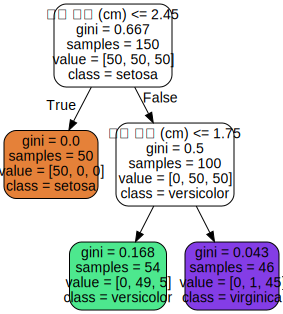

In [28]:
import graphviz
with open("images/decision_trees/iris_tree.dot") as f:
    dot_graph = f.read()
dot = graphviz.Source(dot_graph)
dot.format = 'png'
dot.render(filename='iris_tree', directory='images/decision_trees', cleanup=True)
dot

---
## 6.2 예측하기

위의 트리가 어떻게 예측을 만들어내는지 살펴보겠음<br>
- **루트 노드**<sup>root node</sup>에서 시작<br>
이 노드는 꽃임의 길이가 2.45cm보다 짧은지 검사. 만약 그렇다면 왼쪽의 자식 노드<sup>child node</sup>로 이동<br>
이 경우 이 노드가 **리프 노드**<sup>leaf node</sup>이므로 추가적인 검사를 하지 않음<br>
노드에 있는 예측 클래스(class=setosa)를 보고 결정 트리가 새로 발견한 꽃의 품좀을 Iris-Setosa라고 예측<br>
<br>
이번에는 꽃잎의 길이가 2.45cm보다 긺. 루트 노드의 오른쪽 자식 노드로 이동<br>
이 노드는 리프 노드가 아니라서 추가로 '꽃잎의 너비가 1.75cm보다 작은지' 검사<br>
만약 그렇다면 이 꽃을 Iris-Versicolor로 예측, 그렇지 않다면 Iris-virginica로 예측

**NOTE_** 결정 트리의 여러 장점 중 하나는 데이터 전처리가 거의 필요하지 않다는 것<br>
&emsp;&emsp;&emsp;&emsp;&nbsp;특히 특성의 스케일을 맞추거나 평균을 원점에 맞추는 작업이 필요하지 않음

- 노드의 sample 속성: 얼마나 많은 훈련 샘플이 적용되었는지 헤아린 것<br>
- 노드의 value 속성: 노드에서 각 클래스에 얼마나 많은 훈련 샘플이 있는지 알려줌<br>
- 노드의 gini 속성: **불순도**<sup>impurity</sup>를 측정. 한 노드의 모든 샘플이 같은 클래스에 속해 있다면 이 노드를 순수(gini=0)하다고 함<br>
[식 6-1]은 훈련 알고리즘이 i번째 노드의 gini 점수 G<sub>i</sub>를 계산하는 방법을 보여줌<br>
p<sub>i,k</sub>는 i번째 노드에 있는 훈련 샘플 중 클래스 k에 속한 샘플의 비율<br>
예를 들어 깊이 2의 왼쪽 노드의 gini 점수는 1-(0/54)<sup>2</sup>-(49/54)<sup>2</sup>-(5/54)<sup>2</sup> &asymp; 0.168

<img src="./images/Equation6-1.png" width="20%">
<center>**식 6-1 지니 불순도**</center>

**NOTE_** 사이킷런은 **이진 트리**만 만드는 CART 알고리즘을 사용. 그러므로 리프 노드 외의 모든 노드는 자식 노드를 두 개씩 가짐

[그림 6-2]는 이 결정 트리의 결정 경계를 보여줌

<img src="./images/Figure6-2.png" width="70%">
<center>**그림 6-2 결정 트리의 결정 경계**</center>

**모델 해석: 화이트박스와 블랙박스**
- **화이트박스**<sup>white box</sup> 모델: 결정 트리처럼 매우 직관적이고 결정 방식을 이해하기 쉬운 모델<br>
- **블랙박스**<sup>black box</sup> 모델: 랜덤 포레스트나 신경망이 블랙박스 모델
 - 성능이 뛰어나고 예측을 만드는 연산 과정을 쉽게 확인할 수 있음. 그렇지만 왜 그런 예측을 만드는지는 쉽게 설명하기 어려움
 - 예를 들어 신경망이 어떤 사람이 사진에 있다고 판단했을 때 무엇이 이런 예측을 낳게 했는지 파악하기 매우 어려움

---
## 6.3 클래스 확률 추정

- 결정 트리는 한 샘플이 특정 클래스 k에 속할 확률을 추정할 수 있음

예를 들어 길이가 5cm이고 너비가 1.5cm인 꽃잎을 발견했다고 가정
- 이에 해당하는 리프 노드는 깊이 2에서 왼쪽 노드이므로 결정 트리는 그에 해당하는 확률을 출력
 - Iris-Setosa: 0%(0/54), Iris-Versicolor: 90.7%(49/54), Iris-Virginica: 9.3%(5/54)

In [30]:
tree_clf.predict_proba([[5, 1.5]])

array([[0.        , 0.90740741, 0.09259259]])

클래스를 하나 예측한다면 가장 높은 확률을 가진 Iris-Versicolor(클래스 1)를 출력

In [31]:
tree_clf.predict([[5, 1.5]])

array([1])

---
## 6.4 CART 훈련 알고리즘

- 사이킷런은 결정 트리를 훈련시키기 위해 CART<sup>Classification And Regression Tree</sup> 알고리즘을 사용
- 이 알고리즘의 아이디어
 - 훈련 세트를 하나의 특성 k의 임곗값 t<sub>k</sub>를 사용해 두 개의 서브셋으로 나눔(예를 들면 꽃잎의 길이 &le; 2.45cm)<br>
 - k와 t<sub>k</sub>를 고르는 방식: (크기에 다른 가중치가 적용된) 가장 순수한 서브셋으로 나눌 수 있는 (k, t<sub>k</sub>) 짝을 찾음
 - 이 알고리즘이 최소화해야 하는 비용 함수는 [식 6-2]와 같음 

<img src="./images/Equation6-2.png" width="70%">
<center>**식 6-2 분류에 대한 CART 비용 함수**</center>

- 
 - 훈련 세트를 성공적으로 둘로 나누었다면 같은 방식으로 서브셋을 또 나누고 그다음엔 서브셋의 서브셋을 나누고 이런 식으로 계속 반복<br>
 이 과정은 (max_depth 매개변수로 정의된) 최대 깊이가 되면 중지하거나 불순도를 줄이는 분할을 찾을 수 없을 때 멈추게 됨<br>
 다른 몇 개의 매개변수도 중지 조건에 관여(min_samples_split, min_samples_leaf, min_weight_fraction_leaf, max_leaf_nodes)
 


**CAUTION_** CART 알고리즘은 **탐욕적 알고리즘**<sup>greedy algorithm</sup><br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&nbsp;맨 위 루트 노드에서 최적의 분할을 찾으며 각 단계에서 이 과정을 반복. 현재 단계의 분할이 몇 단계를 거쳐 가장 낮은 불순도로 이어질 수 있을지 고려하지 않음<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&nbsp;탐욕적 알고리즘은 종종 납득할만한 휼륭한 솔루션을 만들어내지만 최적의 솔루션을 보장하지는 않음

- 최적의 트리를 찾는 것은 **NP-완전**<sup>NP-Complete</sup> 문제<br>
이 문제는 O(exp(m)) 시간이 필요하고 매우 작은 훈련 세트에도 적용하기 어려움<br>
그러므로 '납득할 만한 좋은 솔루션'으로만 만족해야 함

---
## 6.5 계산 복잡도

- 예측을 하려면 결정 트리를 루트 노드에서부터 리프 노드까지 탐색해야 함
- 일반적으로 결정 트리는 거의 균형을 이루고 있으므로 결정 트리를 탐색하기 위해서는 약 O(log<sub>2</sub>(m))개의 노드를 거쳐야 함
- 각 노드는 하나의 특성값만 확인하기 때문에 예측에 필요한 전체 복잡도는 특성 수와 무관하게 O(log<sub>2</sub>(m)). 그래서 큰 훈련 세트를 다룰 때도 예측 속도가 매우 빠름
- 훈련 알고리즘은 각 노드에서 모든 훈련 샘플의 모든 특성을 비교함. 그래서 훈련 복잡도는 O(n &times; m log(m))
- 훈련 세트가 (수천 개 이하의 샘플 정도로) 작을 경우 사이킷런은 (presort=True로 지정하면) 미리 데이터를 정렬하여 훈련 속도를 높임<br>
하지만 훈련 세트가 클 경우 속도가 많이 느려짐

---
## 6.6 지니 불순도 또는 엔트로피?

- 기본적으로 지니 불순도가 사용되지만 criterion 매개변수를 "entropy"로 지정하면 **엔트로피** 불순도를 사용
- 엔트로피는 분자의 무질서함을 측정하는 것으로 원래 열역학의 개념. 분자가 안정되고 질서 정연하면 엔트로피가 0에 가까움
- 머신러닝에서는 어떤 세트가 한 클래스의 샘플만 담고 있다면 엔트로피가 0
- [식 6-3]에서 i번째 노드의 엔트로피 정의를 보여줌<br>
[그림 6-1]에서 깊이 2의 왼쪽 노드의 엔트로피는 -$\frac{49}{54}$log<sub>2</sub>($\frac{49}{54}$)-$\frac{5}{54}$log<sub>2</sub>($\frac{5}{54}$) &asymp; 0.445

<img src="./images/Equation6-3.png" width="40%">
<center>**식 6-3 엔트로피**</center>

- 지니 불순도와 엔트로피 중 어떤 것을 사용해야 할까?<br>
 - 지니 불순도가 조금 더 계산이 빠르기 때문에 기본값으로 좋음(로그를 계산할 필요가 없기 때문)
 - 그러나 다른 트리가 만들어지는 경우 지니 불순도가 가장 빈도 높은 클래스를 한쪽 가지<sup>branch</sup>로 고립시키는 경향이 있음
 - 엔트로피는 조금 더 균형 잡힌 트리를 만듦

---
## 6.7 규제 매개변수

- **비파라미터 모델**<sup>nonparametric model</sup>
 - 결정 트리 같이 모델 파라미터가 전혀 없는 것이 아니라 훈련되기 전에 파라미터 수가 결정되지 않는 모델
 - 모델 구조가 데이터에 맞춰져서 고정되지 않고 자유로움
 - 제한을 두지 않으면 훈련 데이터에 아주 가깝게 맞추려고 해서 대부분 과대적합되기 쉬움
- **파라미터 모델**<sup>parametric model</sup>
 - 선형 모델 같이 미리 정의된 모델 파라미터 수를 가짐
 - 자유도가 제한되고 과대적합될 위험이 줄어듦(하지만 과소적합될 위험은 커짐)

- 훈련 데이터에 대한 과대적합을 피하기 위해 학습할 때 모델의 자유도를 제한함. 이를 규제라고 함
- DecisionTreeClassifier에서 결정 트리의 형태를 제한하는 규제 매개변수들
 - max_depth: 결정 트리의 최대 깊이 제어
 - min_samples_split: 분할되기 위해 노드가 가져야 하는 최소 샘플 수
 - min_samples_leaf: 리프 노드가 가지고 있어야 할 최소 샘플 수
 - min_weight_fraction_leaf: min_samples_leaf와 같지만 가중치가 부여된 전체 샘플 수에서의 비율
 - max_leaf_nodes: 리프 노드의 최대 수
 - max_features: 각 노드에서 분할에 사용할 특성의 최대 수
- min으로 시작하는 매개변수를 증가시키거나 max로 시작하는 매개변수를 감소시키면 모델에 규제가 커짐

[그림 6-3]은 moons 데이터셋에 훈련시킨 두 개의 결정 트리를 보여줌
- 왼쪽 모델은 과대적합되었고 오른쪽 모델은 일반화 성능이 좋아보임

<img src="./images/Figure6-3.png" width="90%">
<center>**그림 6-3 min_samples_leaf 매개변수를 사용한 규제**</center>

---
## 6.8 회귀

결정 트리는 회귀 문제에도 사용할 수 있음. 다음은 사이킷런의 DecisionTreeRegressor를 사용해 회귀 트리를 만드는 코드

In [33]:
# 2차식으로 만든 데이터셋 + 잡음
np.random.seed(42)
m = 200
X = np.random.rand(m, 1)
y = 4 * (X - 0.5) ** 2
y = y + np.random.randn(m, 1) / 10

from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

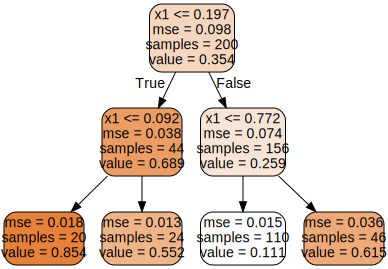

In [35]:
export_graphviz(
        tree_reg,
        out_file=image_path("regression_tree.dot"),
        feature_names=["x1"],
        rounded=True,
        filled=True
    )

import graphviz
with open("images/decision_trees/regression_tree.dot") as f:
    dot_graph = f.read()
dot = graphviz.Source(dot_graph)
dot.format = 'png'
dot.render(filename='regression_tree', directory='images/decision_trees', cleanup=True)
dot

분류 트리와 주요한 차이점
- 각 노드에서 클래스를 예측하는 대신 어떤 값을 예측
- 각 영역의 예측값은 항상 그 영역에 있는 타깃값의 평균. 알고리즘은 예측값과 가능한 한 많은 샘플이 가까이 있도록 영역을 분할

이 모델의 예측은 아래 [그림 6-5]의 왼쪽에 나타나 있고, max_depth=3으로 설정하면 오른쪽 그래프와 같은 예측을 얻게 됨

<img src="./images/Figure6-5.png" width="90%">
<center>**그림 6-5 두 개의 결정 트리 회귀 모델의 예측**</center>

- 이 예측값을 사용해 한 노드의 모든 샘플에 대한 평균제곱오차(MSE)를 계산
- CART 알고리즘은 평균제곱오차(MSE)를 최소화하도록 분할
- [식 6-4]는 알고리즘이 최소화하기 위한 비용 함수를 보여줌

<img src="./images/Equation6-4.png" width="80%">
<center>**식 6-4 회귀를 위한 CART 비용 함수**</center>

분류에서와 같이 회귀 작업에서도 결정 트리가 과대적합되기 쉬움
- 규제가 없다면(즉, 기본 매개변수를 사용하면) 아래 [그림 6-6]의 왼쪽과 같은 예측을 함. 훈련세트에 과대적합됨
- min_samples_leaf=10으로 지정하면 훨씬 그럴싸한 모델을 만들어줌

<img src="./images/Figure6-6.png" width="90%">
<center>**그림 6-6 결정 트리 회귀 모델의 규제**</center>

---
## 6.9 불안정성

결정 트리의 제한사항
- 결정 트리는 계단 모양의 결정 경계를 만듦(모든 분할은 축에 수직). 그래서 훈련 세트의 회전에 민감<br>
아래 [그림 6-7]의 왼쪽 결정 트리는 쉽게 데이터셋을 구분하지만, 데이터셋을 45&deg; 회전한 오른쪽의 결정 트리는 불필요하게 구불구불해져 잘 일반화될 것 같지 않음
- 이런 문제를 해결하는 한 가지 방법은 훈련 데이터를 더 좋은 방향으로 회전시키는 PCA 기법을 사용하는 것(8장 참조)

<img src="./images/Figure6-7.png" width="90%">
<center>**그림 6-7 훈련 세트의 회전에 민감한 결정 트리**</center>

- 결정 트리의 주된 문제는 훈련 데이터에 있는 작은 변화에도 매우 민감하다는 것<br>
훈련 세트에서 가장 넓은 Iris-Versicolor(꽃잎 길이가 4.8cm이고 너비가 1.8cm인 것)를 제거하고 결정 트리를 훈련시키면 [그림 6-8]과 같은 모델을 얻게 됨<br>
이전에 만든 결정 트리(그림 6-2)와는 매우 다른 모습임

<img src="./images/Figure6-8.png" width="70%">
<center>**그림 6-8 훈련 세트의 세부사항에 민감한 결정 트리**</center>

- 랜덤 포레스트는 많은 트리에서 만든 예측을 평균하여 이런 불안정성을 극복할 수 있음

---
## 6.10 연습문제

1.백만 개의 샘플을 가진 훈련 세트에서 (규제 없이) 훈련시킨 결정 트리의 깊이는 대략 얼마일까요?

- m개의 리프 노드를 포함한 균형이 잘 잡힌 이진 트리의 깊이: log<sub>2</sub>(m)
- 결정 트리를 제한을 두지 않고 훈련시키면 훈련 샘플마다 하나의 리프 노드가 되므로 어느 정도 균형이 잘 잡힌 트리가 됨
- 훈련 세트에 백만 개 샘플이 있다면 결정 트리의 깊이는 log<sub>2</sub>(10<sup>6</sup>) &asymp; 20 (실제로는 완벽하게 균형 잡힌 트리가 만들어지지 않기 때문에 조금 더 늘어남)

---
2.한 노드의 지니 불순도가 보통 그 부모 노드보다 작을까요, 아니면 클까요? 일반적으로 작거나 클까요, 아니면 항상 작거나 클까요?

- 자식의 지니 불순도의 가중치 합이 최소화되는 방향으로 각 노드를 분할하는 CART 훈련알고리즘의 비용함수 때문에 한 노드의 지니 불순도는 일반적으로 부모의 불순도보다 낮음
- 그러나 다른 자식 노드의 지니 불순도 감소량이 어떤 노드의 불순도 증가량보다 큰 경우라면 부모의 불순도보다 큰 노드가 생길 수 있음<br>
예를 들어 **<font color="blue">클래스 A의 샘플을 4개, 클래스 B의 샘플을 1개</font>** 포함한 노드를 생각해보겠습니다. 이 노드의 **<font color="blue">지니 불순도는 1-$\left ( \frac{1}{5} \right )^2$-$\left ( \frac{4}{5} \right )^2$ = 0.32</font>** 입니다. 이 데이터셋은 **<font color="blue">1차원이고 A, B, A, A, A 순</font>**으로 늘어서 있다고 가정하겠습니다. 알고리즘이 이 노드를 두 번째 샘플 이후에 나누어 **<font color="blue">샘플 A, B를 가진 자식 노드</font>**와 **<font color="blue">샘플 A, A, A를 가진 자식 노드</font>**를 만듭니다. 첫 번째 자식 노드의 **<font color="blue">지니 불순도는 1-$\left ( \frac{1}{2} \right )^2$-$\left ( \frac{1}{2} \right )^2$ = 0.5</font>**가 되어 부모보다 큽니다. 이는 다른 노드가 **<font color="blue">순수 노드</font>**가 되는 것에 대한 대가입니다. 가중치를 준 전체 지니 불순도는 $\frac{2}{5}$&times;0.5 + $\frac{3}{5}$&times;0 = 0.2가 되어 부모의 지니 불순도보다 낮습니다.

---
3.결정 트리가 훈련 세트에 과대적합되었다면 max_depth를 줄이는 것이 좋을까요?

- 모델에 제약을 가해 규제해야 하므로 max_depth를 낮추는 것이 좋음

---
4.결정 트리가 훈련 세트에 과소적합되었다면 입력 특성의 스케일을 조정하는 것이 좋을까요?

- 결정 트리는 훈련 데이터의 스케일이나 원점에 맞추어져 있는지 상관하지 않음. 이것이 결정 트리의 장점
- 결정 트리가 훈련 세트에 과소적합되었다고 입력 특성의 스케일을 조정하는 것은 시간 낭비임

---
5.백만 개의 샘플을 가진 훈련 세트에 결정 트리를 훈련시키는 데 한 시간이 걸렸다면, 천만 개의 샘플을 가진 훈련 세트에 결정 트리를 훈련시키는 데는 대략 얼마나 걸릴까요?

- 결정 트리 훈련의 계산 복잡도: O(n &times; m log(m)) &emsp; n: 특성 수, m: 샘플 수
- 샘플이 10배 늘어났으므로 훈련시간은 (n &times; 10m log(10m)) / (n &times; m log(m)) = 10 &times; log(10m) / log(m) 배 늘어남
- m = 10<sup>6</sup>이므로 훈련에 대략 11.7시간이 걸릴 것으로 예상됨

---
6.십만 개의 샘플을 가진 훈련 세트가 있다면 presort=True로 지정하는 것이 훈련 속도를 높일까요?

- 데이터셋의 샘플 수가 수천 개 미만일 때 훈련 세트를 사전에 정렬하여 훈련 속도를 높일 수 있음
- 십만 개의 샘플을 포함하고 있을 때 presort=True로 지정하면 훈련 속도가 매우 느려질 것임

---
7.moons 데이터셋에 결정 트리를 훈련시키고 세밀하게 튜닝해보세요.

a. make_moons(n_samples=1000, noise=0.4)를 사용해 데이터셋을 생성합니다.<br>
random_state=42를 지정하여 결과를 일정하게 만듭니다:

In [104]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=10000, noise=0.4, random_state=42)

b. 이를 train_test_split()을 사용해 훈련 세트와 테스트 세트로 나눕니다.

In [105]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

c. DecisionTreeClassifier의 최적의 매개변수를 찾기 위해 교차 검증과 함께 그리드 탐색을 수행합니다.(GridSearchCV를 사용하면 됩니다).<br>
&emsp; 힌트: 여러 가지 max_leaf_nodes 값을 시도해보세요.

In [106]:
from sklearn.model_selection import GridSearchCV

params = {'max_leaf_nodes': list(range(2, 100))}
grid_search_cv = GridSearchCV(DecisionTreeClassifier(random_state=42), params, cv=3, n_jobs=-1)

grid_search_cv.fit(X_train, y_train)
grid_search_cv.best_params_

{'max_leaf_nodes': 17}

d. 찾은 매개변수를 사용해 전체 훈련 세트에 대해 모델을 훈련시키고 테스트 세트에서 성능을 측정합니다. 대략 85~87%의 정확도가 나올 것입니다.

기본적으로 GridSearchCV는 전체 훈련 세트로 찾은 최적의 모델을 다시 훈련시킵니다(refit=False로 지정해서 바꿀 수 있습니다). 그래서 별도로 작업할 필요가 없습니다. 모델의 정확도를 바로 평가할 수 있습니다:

In [107]:
from sklearn.metrics import accuracy_score

y_pred = grid_search_cv.predict(X_test)
accuracy_score(y_test, y_pred)

0.8695

---
8.랜덤 포레스트를 만들어보세요.

a. 이전 연습문제에 이어서, 훈련 세트의 서브셋을 1,000개 생성합니다. 각각은 무작위로 선택된 100개의 샘플을 담고 있습니다.<br>
&emsp;&nbsp;힌트: 사이킷런의 ShuffleSplit을 사용할 수 있습니다.

In [108]:
from sklearn.model_selection import ShuffleSplit

n_trees = 1000
n_instances = 100

mini_sets = []

rs = ShuffleSplit(n_splits=n_trees, test_size=len(X_train) - n_instances, random_state=42)
for mini_train_index, mini_test_index in rs.split(X_train):
    X_mini_train = X_train[mini_train_index]
    y_mini_train = y_train[mini_train_index]
    mini_sets.append((X_mini_train, y_mini_train))

b. 앞에서 찾은 최적의 매개변수를 사용해 각 서브셋에 결정 트리를 훈련시킵니다. 테스트 세트로 이 1,000개의 결정 트리를 평가합니다.<br>
&emsp;&nbsp;더 작은 데이터셋에서 훈련되었기 때문에 이 결정 트리는 앞서 만든 결정 트리보다 성능이 떨어져 약 80%의 정확도를 냅니다.

In [109]:
from sklearn.base import clone

forest = [clone(grid_search_cv.best_estimator_) for _ in range(n_trees)]

accuracy_scores = []

for tree, (X_mini_train, y_mini_train) in zip(forest, mini_sets):
    tree.fit(X_mini_train, y_mini_train)
    
    y_pred = tree.predict(X_test)
    accuracy_scores.append(accuracy_score(y_test, y_pred))

np.mean(accuracy_scores)

0.8054499999999999

c. 이제 마술을 부릴 차례입니다. 각 테스트 세트 샘플에 대해 1,000개의 결정 트리 예측을 만들고 다수로 나온 예측만 취합니다(사이파이의 mode() 함수를 사용할 수 있습니다).<br>
&emsp;&nbsp;그러면 테스트 세트에 대한 **다수결 예측**<sup>majority-vote prediction</sup>이 만들어집니다.<br>

In [110]:
Y_pred = np.empty([n_trees, len(X_test)], dtype=np.uint8) # 1000*2000 empty 배열 선언

for tree_index, tree in enumerate(forest): # 내장함수 enumerate(): 순서가 있는 자료형의 값을 인덱스와 함께 반환
    Y_pred[tree_index] = tree.predict(X_test)

In [118]:
print(Y_pred.shape)
Y_pred

(1000, 2000)


array([[0, 1, 0, ..., 0, 0, 1],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 1],
       ...,
       [1, 1, 0, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 1],
       [1, 1, 0, ..., 0, 0, 0]], dtype=uint8)

In [113]:
from scipy.stats import mode

y_pred_majority_votes, n_votes = mode(Y_pred, axis=0) # 최빈값과 빈도수 반환

In [128]:
y_pred_majority_votes

array([[1, 1, 0, ..., 0, 0, 0]], dtype=uint8)

In [123]:
n_votes

array([[951, 912, 963, ..., 919, 994, 602]])

d. 테스트 세트에서 이 예측을 평가합니다. 앞서 만든 모델보다 조금 높은(약 0.5~1.5% 정도) 정확도를 얻게 될 것입니다. 축하합니다. 랜덤 포레스트 분류기를 훈련시켰습니다!

In [114]:
accuracy_score(y_test, y_pred_majority_votes.reshape([-1]))

0.872